In [1]:
# Importing Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import os
from google.colab import drive
from glob import glob
import time
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Flatten, Dense
from sklearn.metrics import roc_curve, auc, accuracy_score

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/MyDrive/Balanced Dataset'

Mounted at /content/drive


In [5]:
# Use ImageDataGenerator for data loading and augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [6]:
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42
)

Found 21000 images belonging to 10 classes.
Found 9000 images belonging to 10 classes.


In [7]:
# Build a deeper CNN model with dropout for regularization
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model using the generators
import time
from tensorflow.keras.callbacks import ModelCheckpoint

# Define a callback to print a message and keep the session active
class KeepSessionActiveAndSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Colab is active! Epoch:", epoch + 1)
        # Save the model after each epoch
        self.model.save("/content/drive/MyDrive/B_Own2_10epoch.h5".format(epoch + 1))
# Train the model
model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[KeepSessionActiveAndSaveModel()]
)

Epoch 1/10
657/657 [==============================] - 238s 363ms/step - loss: 0.4031 - accuracy: 0.8620 - val_loss: 0.4920 - val_accuracy: 0.8371
Epoch 2/10
657/657 [==============================] - 238s 362ms/step - loss: 0.3675 - accuracy: 0.8710 - val_loss: 0.3936 - val_accuracy: 0.8636
Epoch 3/10
657/657 [==============================] - 223s 339ms/step - loss: 0.3169 - accuracy: 0.8916 - val_loss: 0.4270 - val_accuracy: 0.8617
Epoch 4/10
657/657 [==============================] - 235s 357ms/step - loss: 0.2891 - accuracy: 0.8997 - val_loss: 0.4727 - val_accuracy: 0.8461
Epoch 5/10
657/657 [==============================] - 223s 340ms/step - loss: 0.2575 - accuracy: 0.9115 - val_loss: 0.5213 - val_accuracy: 0.8421
Epoch 6/10
657/657 [==============================] - 227s 345ms/step - loss: 0.2367 - accuracy: 0.9191 - val_loss: 0.5157 - val_accuracy: 0.8409
Epoch 7/10
657/657 [==============================] - 235s 358ms/step - loss: 0.2152 - accuracy: 0.9260 - val_loss: 0.4973 -

Found 1000 images belonging to 10 classes.
32/32 [==============================] - 324s 10s/step


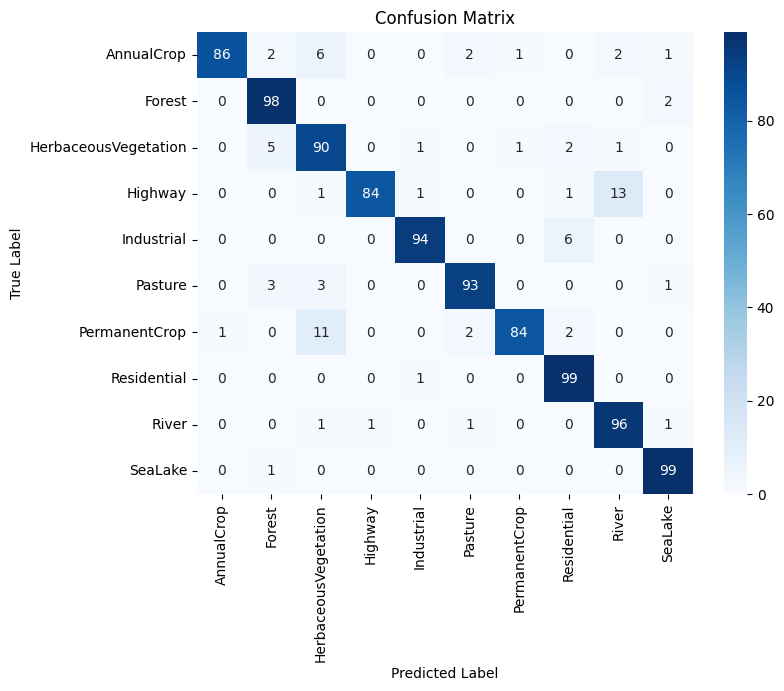

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.99      0.86      0.92       100
              Forest       0.90      0.98      0.94       100
HerbaceousVegetation       0.80      0.90      0.85       100
             Highway       0.99      0.84      0.91       100
          Industrial       0.97      0.94      0.95       100
             Pasture       0.95      0.93      0.94       100
       PermanentCrop       0.98      0.84      0.90       100
         Residential       0.90      0.99      0.94       100
               River       0.86      0.96      0.91       100
             SeaLake       0.95      0.99      0.97       100

            accuracy                           0.92      1000
           macro avg       0.93      0.92      0.92      1000
        weighted avg       0.93      0.92      0.92      1000



In [2]:
# Load the pre-trained model from the .h5 file
model = load_model('/content/drive/MyDrive/B_Own2_10epoch.h5')

# Define the test dataset directory
test_data_dir = '/content/drive/MyDrive/Testing Dataset'

# Set the input size of the model
input_size = (64, 64)

# Set batch size for data generator
batch_size = 32

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test dataset
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(64,64),
    batch_size=32,
    class_mode='categorical',  # Change to 'binary' if you have binary classification
    shuffle=False  # Set to False to maintain order for evaluation
)
# Generate predictions for the test dataset
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = test_generator.classes

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix with numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Generate and print classification report
class_report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)
print("Classification Report:")
print(class_report)

<ipython-input-3-fd14690ae517>:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')


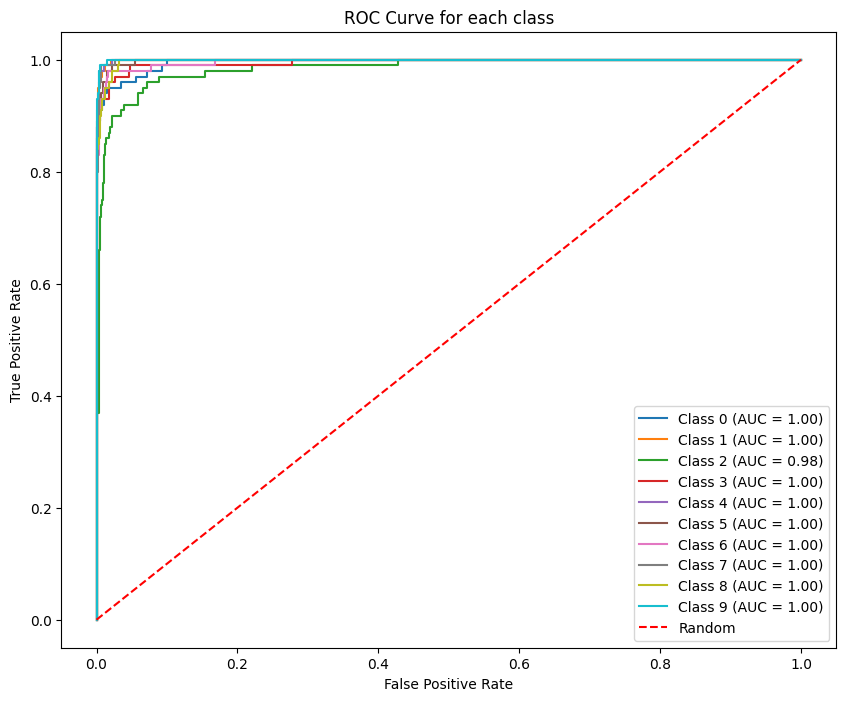

In [3]:
# Compute ROC curve and AUC for each class
fpr = dict()

tpr = dict()
roc_auc = dict()

for i in range(test_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(test_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', color='red', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc='best')
plt.show()


In [4]:
# Compute accuracy using other metrics
accuracy = accuracy_score(true_labels, predicted_labels) * 100
print(accuracy)

92.30000000000001


In [5]:
# Calculate Additional Metrics
# Define the number of classes
num_classes = len(test_generator.class_indices)

# Set a common threshold for binary classification
threshold = 0.5

# Convert predicted probabilities to binary predictions
predicted_labels_binary = (predictions > threshold).astype(int)

# Extract True Positive (TP), False Positive (FP), True Negative (TN), False Negative (FN)
tp = int((accuracy / 100) * len(true_labels))
fp = len(true_labels) - tp
tn = int((accuracy / 100) * len(true_labels))
fn = len(true_labels) - tn

# Calculate True Positive Rate (TPR), False Positive Rate (FPR), Precision, Recall, F1 Score
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
precision = tp / (tp + fp)
recall = tpr
f1 = 2 * (precision * recall) / (precision + recall)

# Calculate Area Under ROC Curve (AUC)
roc_auc = dict()
for i in range(num_classes):
    fpr_i, tpr_i, _ = roc_curve(true_labels, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr_i, tpr_i)

# Display the computed metrics for the dataset
print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Area Under ROC Curve (AUC): {np.mean(list(roc_auc.values())):.4f}")

True Positive Rate (TPR): 0.9230
False Positive Rate (FPR): 0.0770
Precision: 0.9230
Recall: 0.9230
F1 Score: 0.9230
Area Under ROC Curve (AUC): 0.9965
